Mohamed Yunes, Nour Saneh

# Setting up
Loading the dataset from kaggle

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download fedesoriano/heart-failure-prediction
! unzip heart-failure-prediction.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
License(s): ODbL-1.0
heart-failure-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  heart-failure-prediction.zip
replace heart.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv("/content/heart.csv")


# Exploratory Data Analysis
Cleaning up the dataset and preparing it for training


In [ ]:
#General idea of what the dataset looks like
print('Info: \n')
print( df.info())
print('Head: \n')
print( df.head())
print('Describe: \n')
print( df.describe())

Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None
Head: 

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F         

In [ ]:
#Fixing cholesterol outlier using IQR
iqr = df['Cholesterol'].quantile(0.75) - df['Cholesterol'].quantile(0.25)
lower_bound = df['Cholesterol'].quantile(0.25) - 1.5 * iqr
upper_bound = df['Cholesterol'].quantile(0.75) + 1.5 * iqr
df['Cholesterol'] = df['Cholesterol'].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,203.985158,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,95.922341,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,32.625000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,407.625000,1.000000,202.000000,6.200000,1.000000


In [ ]:
#Cleaning the dataset:
df.drop_duplicates(inplace=True) #removing duplicated values if present
df.dropna(inplace=True) #removing missing values if present

In [ ]:
#Noticeable disparity in sex which will be addressed later
df['Sex'].value_counts(normalize=True) * 100

,proportion
Sex,
M,78.976035
F,21.023965


In [ ]:
#Slightly unbalanced target field which will also be addressed
df['HeartDisease'].value_counts(normalize=True) * 100

,proportion
HeartDisease,
1,55.337691
0,44.662309


In [ ]:
from sklearn.preprocessing import LabelEncoder
#label encoding
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['ChestPainType'] = label_encoder.fit_transform(df['ChestPainType'])
df['RestingECG'] = label_encoder.fit_transform(df['RestingECG'])
df['ExerciseAngina'] = label_encoder.fit_transform(df['ExerciseAngina'])
df['ST_Slope'] = label_encoder.fit_transform(df['ST_Slope'])

#onehot
#df = pd.get_dummies(df, columns=['ChestPainType', 'ExerciseAngina', 'RestingECG', 'ST_Slope'], dtype='int')

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289.0,0,1,172,0,0.0,2,0
1,49,0,2,160,180.0,0,1,156,0,1.0,1,1
2,37,1,1,130,283.0,0,2,98,0,0.0,2,0
3,48,0,0,138,214.0,0,1,108,1,1.5,1,1
4,54,1,2,150,195.0,0,1,122,0,0.0,2,0


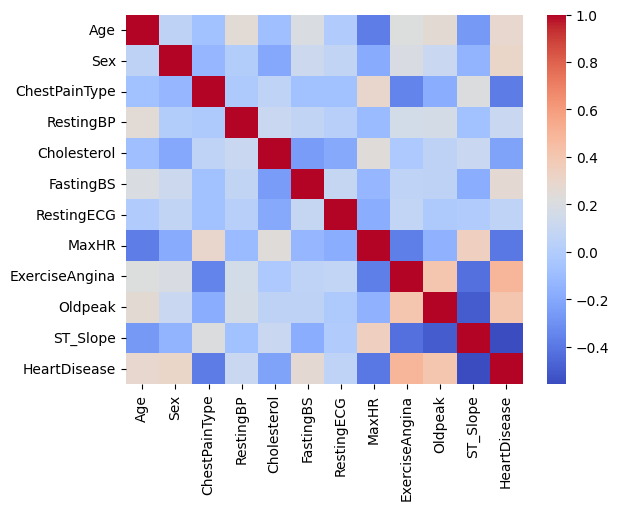

In [ ]:
#checking correlation
corr_matrix = df.corr()
for i in corr_matrix.columns:
  for j in corr_matrix.index:
    if (0.8 < abs(corr_matrix.at[j,i]) < 1.0):
      print(f"High correlation between {i} and {j}: {corr_matrix.loc[j,i]}")

import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr_matrix, annot=False,cmap='coolwarm')
plt.show()

#Training
Splitting and normalizing the data:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#splitting the data 20% for training 80% for testing
x = df.drop(columns=["HeartDisease"])
y = df["HeartDisease"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#scaling
MM_scaler = MinMaxScaler()
x_train = MM_scaler.fit_transform(x_train)
x_test = MM_scaler.fit(x_test)




In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#Now we can fit and test the models

**Gaussian**

Gaussian Naive Bayes Accuracy: 0.8315217391304348%
Gaussian Naive Bayes Confusion Matrix:
[[59 18]
 [13 94]]
Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        77
           1       0.84      0.88      0.86       107

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.83       184
weighted avg       0.83      0.83      0.83       184



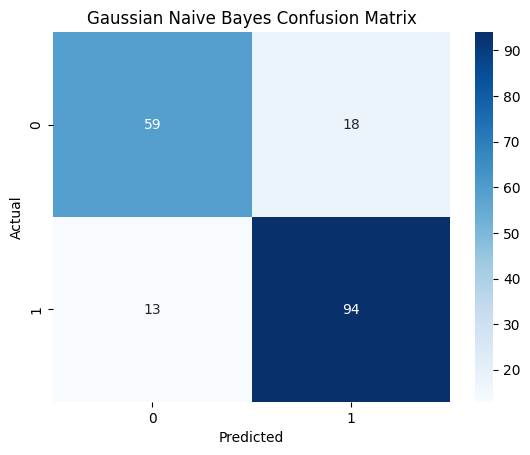

In [ ]:

#Starting with Gaussian Naive Bayes
nbmodel = GaussianNB()
nbmodel.fit(x_train, y_train)

#Testing model
nbmodel_prediction = nbmodel.predict(x_test)

nbmodel_accuracy = accuracy_score(y_test, nbmodel_prediction)
print(f"Gaussian Naive Bayes Accuracy: {nbmodel_accuracy}%")

nbconfusion = confusion_matrix(y_test, nbmodel_prediction)
print("Gaussian Naive Bayes Confusion Matrix:")
print(nbconfusion)

nbclassification = classification_report(y_test, nbmodel_prediction)
print("Gaussian Naive Bayes Classification Report:")
print(nbclassification)

#Visualizing results
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(nbconfusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gaussian Naive Bayes Confusion Matrix")
plt.show()


**Logistic Regression**

Logistic Regression Accuracy: 0.8315217391304348%
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.88      0.81        77
           1       0.90      0.79      0.85       107

    accuracy                           0.83       184
   macro avg       0.83      0.84      0.83       184
weighted avg       0.84      0.83      0.83       184



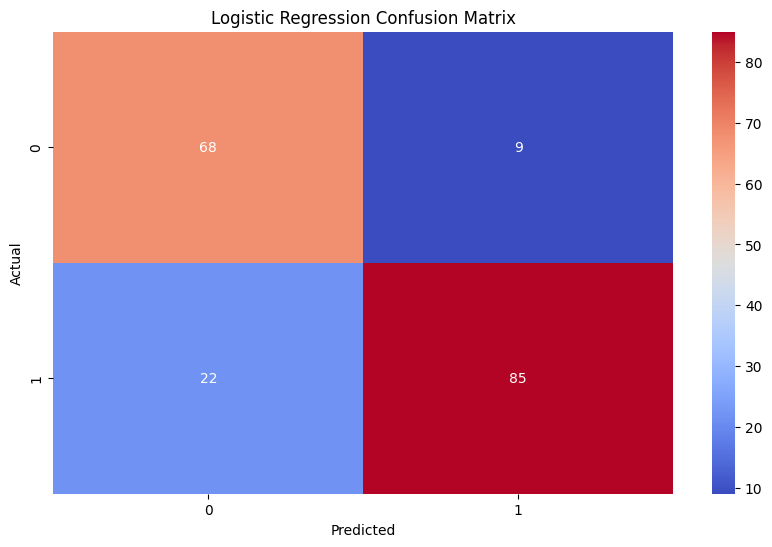

In [ ]:
#Logistic Regression
lrmodel = LogisticRegression()
lrmodel.fit(x_train, y_train)

#Testing model
lrmodel_prediction = lrmodel.predict(x_test)

lrmodel_accuracy = accuracy_score(y_test, lrmodel_prediction)
print(f"Logistic Regression Accuracy: {lrmodel_accuracy}%")

lrclassification = classification_report(y_test, lrmodel_prediction)
print("Logistic Regression Classification Report:")
print(lrclassification)

lrconfusion = confusion_matrix(y_test, lrmodel_prediction)
plt.figure(figsize=(10, 6))
sns.heatmap(lrconfusion, annot=True, fmt="d", cmap="coolwarm")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

**K Nearest Neighbor**

(7, 0.8641304347826086)


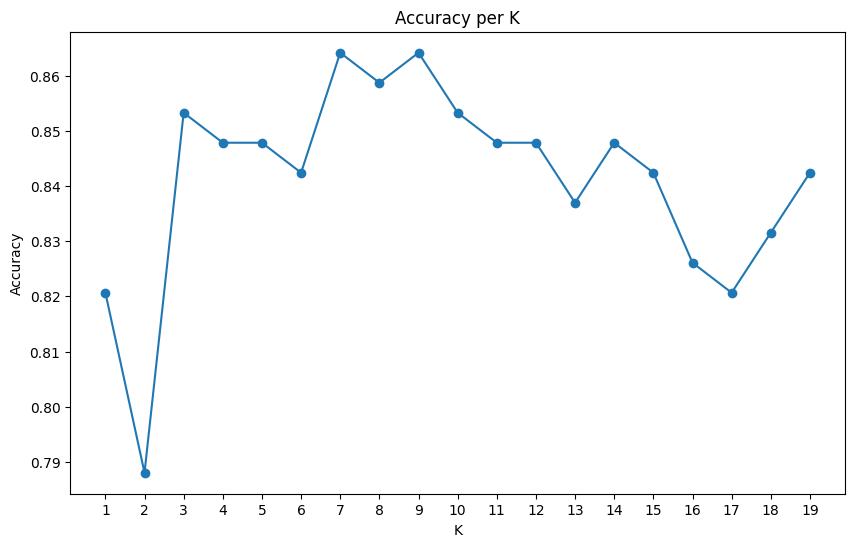

In [ ]:
#KNN

#finding best K
klist = []
bestk = 1
for k in range(1, 20):
    knnmodel = KNeighborsClassifier(n_neighbors=k)
    knnmodel.fit(x_train, y_train)
    knnmodel_prediction = knnmodel.predict(x_test)
    accuracy = accuracy_score(y_test, knnmodel_prediction)
    klist.append((k, accuracy))
    if accuracy > bestk:
        bestk = k

plt.figure(figsize=(10, 6))
plt.plot([k for k, _ in klist], [accuracy for _, accuracy in klist], marker='o')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy per K')
plt.xticks(range(1, 20))


print(max(klist, key=lambda x: x[1]))


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        77
           1       0.84      0.88      0.86       107

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.83       184
weighted avg       0.83      0.83      0.83       184



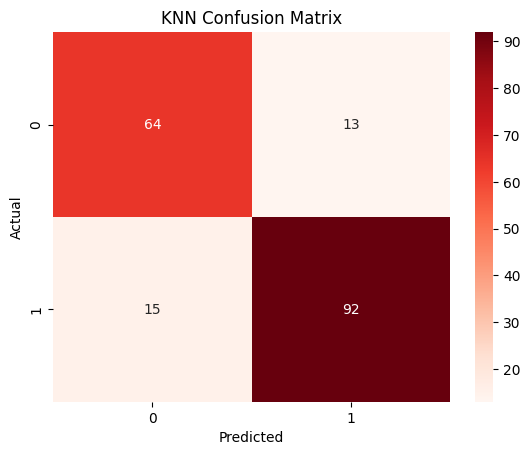

In [ ]:
#KNN using k = 11
knnmodel = KNeighborsClassifier(n_neighbors=11)
knnmodel.fit(x_train, y_train)
knnmodel_prediction = knnmodel.predict(x_test)

knnmodel_accuracy = accuracy_score(y_test, knnmodel_prediction)

knnconfusion = confusion_matrix(y_test, knnmodel_prediction)

knnclassification = classification_report(y_test, knnmodel_prediction)
print("KNN Classification Report:")
print(nbclassification)

sns.heatmap(knnconfusion, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Confusion Matrix")
plt.show()

 **Random Forest**

(15, 0.8967391304347826)


Text(0.5, 1.0, 'Accuracy per Depth')

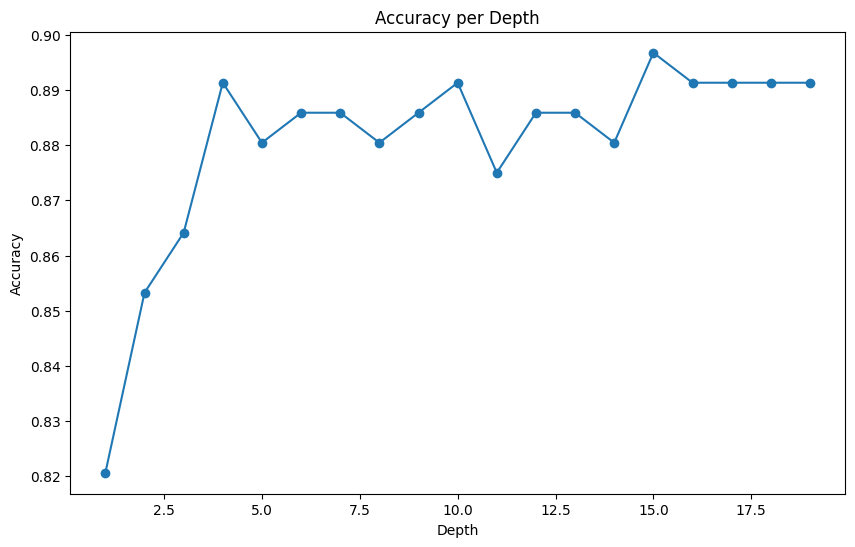

In [ ]:
#Finding best depth
depthlist = []
for depth in range(1, 20):
    rfmodel = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42)
    rfmodel.fit(x_train, y_train)
    rfmodel_prediction = rfmodel.predict(x_test)
    accuracy = accuracy_score(y_test, rfmodel_prediction)
    depthlist.append((depth, accuracy))

print(max(depthlist, key=lambda x: x[1]))

plt.figure(figsize=(10, 6))
plt.plot([depth for depth, _ in depthlist], [accuracy for _, accuracy in depthlist], marker='o')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy per Depth')


Random Forest Accuracy: 0.8858695652173914%
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        77
           1       0.91      0.89      0.90       107

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184



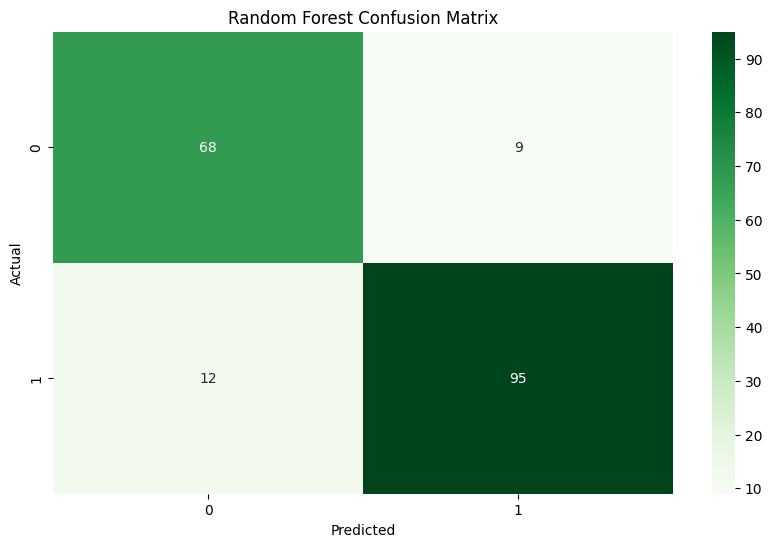

In [ ]:
#Random Forest with depth = 7
rfmodel = RandomForestClassifier(n_estimators=100, max_depth = 13, random_state=42)
rfmodel.fit(x_train, y_train)

#Testing model
rfmodel_prediction = rfmodel.predict(x_test)

rfmodel_accuracy = accuracy_score(y_test, rfmodel_prediction)
print(f"Random Forest Accuracy: {rfmodel_accuracy}%")

rfclassification = classification_report(y_test, rfmodel_prediction)
print("Random Forest Classification Report:")
print(rfclassification)

rfconfusion = confusion_matrix(y_test, rfmodel_prediction)
plt.figure(figsize=(10, 6))
sns.heatmap(rfconfusion, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

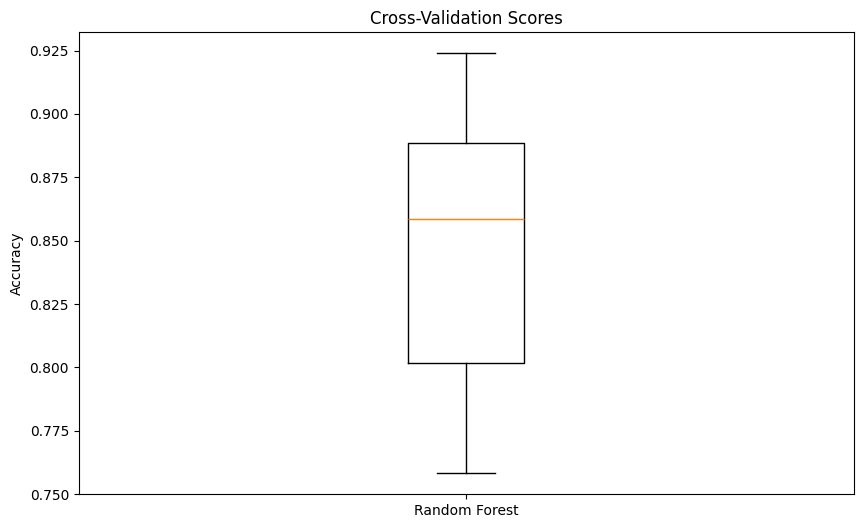

In [ ]:
#cross validation for random forest
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(MinMaxScaler(), RandomForestClassifier(max_depth = 13, random_state=42))
scores = cross_val_score(pipeline, x, y, cv=10)

plt.figure(figsize=(10, 6))
plt.boxplot(scores)
plt.xticks([1], ['Random Forest'])
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.show()

#Comparing models

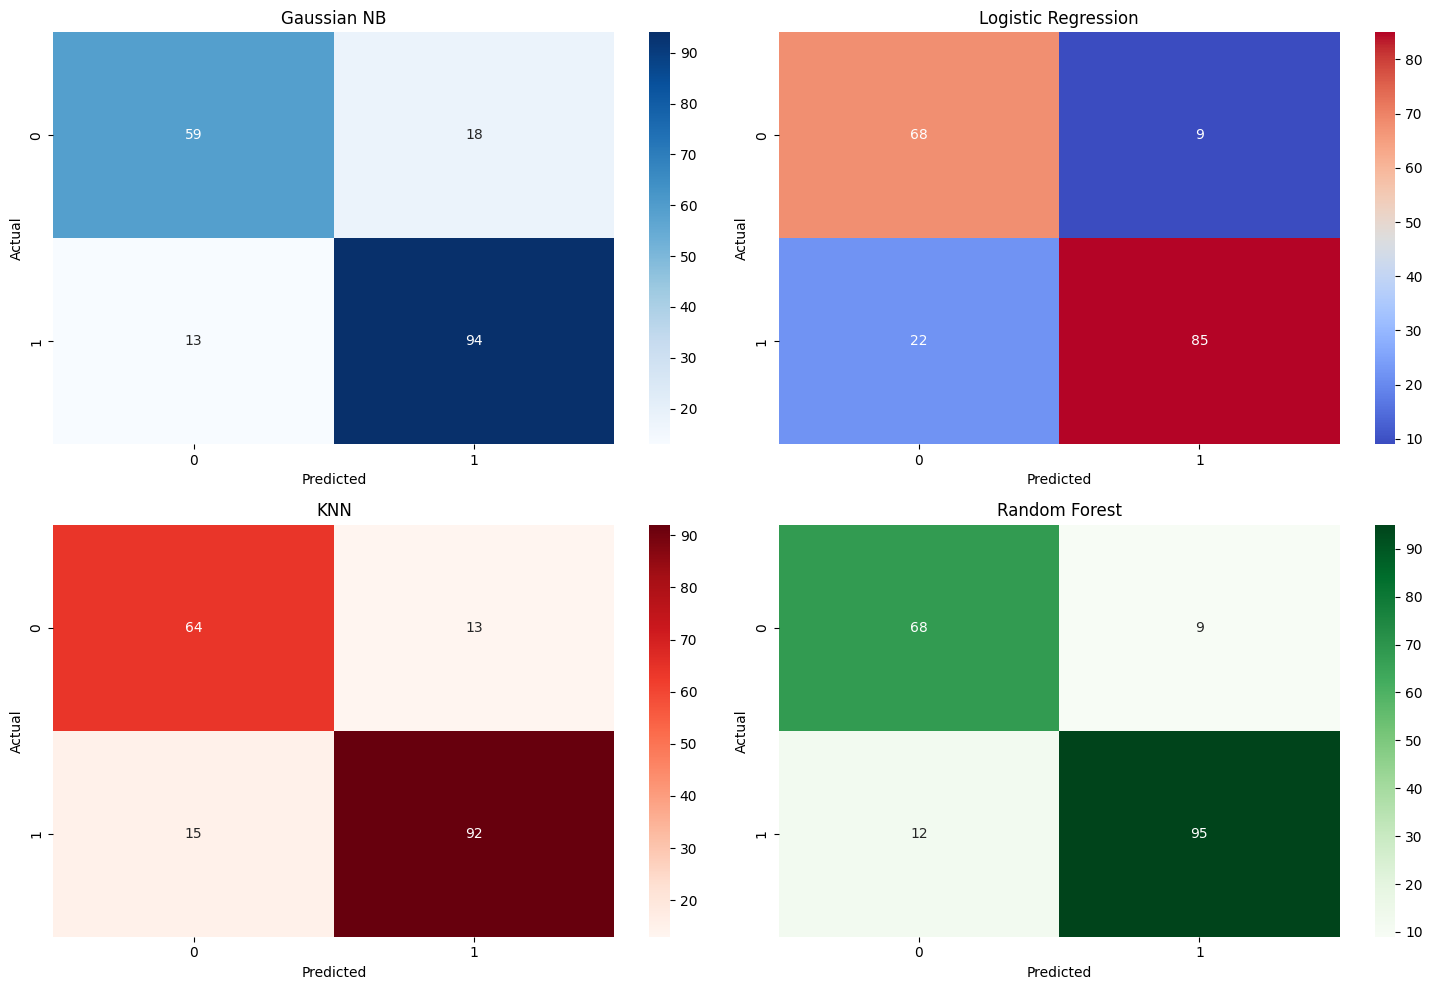

In [ ]:

#Confusion matrices all together
matrices = [nbconfusion, lrconfusion, knnconfusion, rfconfusion]
titles = ["Gaussian NB", "Logistic Regression", "KNN", "Random Forest"]
cmap_list = ["Blues", "coolwarm", "Reds", "Greens"]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
  sns.heatmap(matrices[i], annot=True, fmt="d", cmap=cmap_list[i], ax=ax)
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Actual")
  ax.set_title(titles[i])
plt.tight_layout()
plt.show()

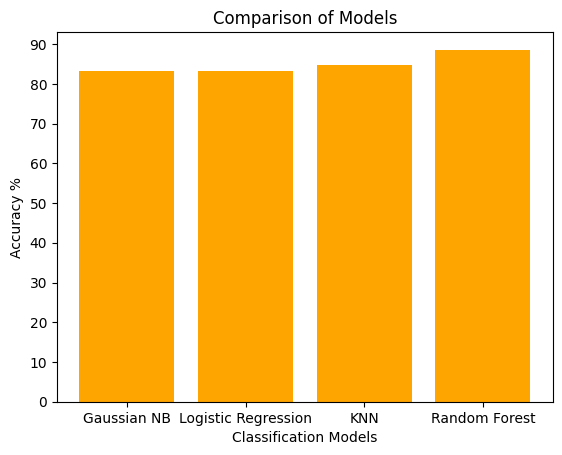

In [ ]:
#Comparing accuracies
accuracies = [nbmodel_accuracy*100, lrmodel_accuracy*100, knnmodel_accuracy*100, rfmodel_accuracy*100]
plt.bar(titles, accuracies, color="orange")
plt.xlabel("Classification Models")
plt.ylabel("Accuracy %")
plt.title("Comparison of Models")
plt.yticks(range(0, 100, 10))
plt.show()

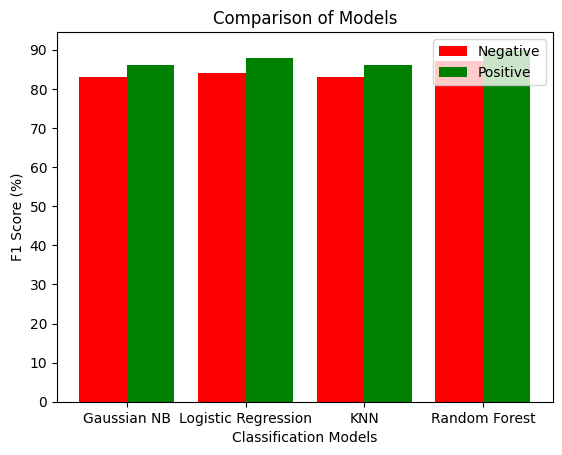

In [ ]:
#Comparing f1 scores
f1scores = [(83, 86), (84,88), (83,  86), (87, 90)]
plt.bar(np.arange(len(titles)) - 0.2, [i[0] for i in f1scores] , 0.4, color="red", label = 'Negative')
plt.bar(np.arange(len(titles)) + 0.2, [i[1] for i in f1scores], 0.4, color="green", label = 'Positive')
plt.legend()
plt.xlabel("Classification Models")
plt.ylabel("F1 Score (%)")
plt.title("Comparison of Models")
plt.xticks(np.arange(len(titles)), titles)
plt.yticks(range(0, 100, 10))
plt.show()